# Selección de data meteorológica ERA5
Paquetes

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import (
    Point, 
    box,
)
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # For progress tracking

Constantes

In [3]:
# Path del Shapefile de Azuay
azuay_shapefile_path = 'shape_data/LIMITE_AZUAY_PROVINCIA/LIMITE_AZUAY_PROVINCIA.shp'
# Path del Shapefile de Cuenca
cuenca_shapefile_path = 'shape_data/LIMITE_CUENCA_CANTON/LIMITE_CUENCA_CANTON.shp'
# Default CRS
default_crs = 'EPSG:4326'

# Datos dentro de Azuay


## Grilla ERA5 sobre Azuay

Definimos una función para graficar una grilla sobre el polígono de Azuay

In [4]:
# ClaudeAI
# Load city shapefile
def create_era5_grid_overlay(city_shapefile_path, 
                             era5_resolution=0.25, 
                             buffer_degrees=0.5,
                             plot_crs:str=default_crs):
    """
    Create an ERA5 grid overlay on a city shapefile.
    
    Parameters:
    -----------
    city_shapefile_path : str
        Path to the city shapefile
    era5_resolution : float
        Resolution of ERA5 data in degrees (default: 0.25 for standard ERA5)
    buffer_degrees : float
        Buffer around the city extent in degrees to ensure complete coverage
        
    Returns:
    --------
    fig : matplotlib figure
        Figure with the city shapefile and ERA5 grid overlay
    """
    # Read the shapefile
    city_gdf = gpd.read_file(city_shapefile_path)
    
    # Ensure the GeoDataFrame is in a geographic coordinate system (WGS84)
    city_gdf = city_gdf.to_crs(plot_crs)
    
    # Get the bounds of the city (with buffer)
    bounds = city_gdf.total_bounds
    min_x = bounds[0] - buffer_degrees
    min_y = bounds[1] - buffer_degrees
    max_x = bounds[2] + buffer_degrees
    max_y = bounds[3] + buffer_degrees
    
    # Create ERA5 grid cells
    grid_cells = []
    grid_ids = []
    count = 0
    
    # Generate grid cells
    for x in np.arange(min_x, max_x, era5_resolution):
        for y in np.arange(min_y, max_y, era5_resolution):
            cell = box(x, y, x + era5_resolution, y + era5_resolution)
            grid_cells.append(cell)
            grid_ids.append(count)
            count += 1
    
    # Create a GeoDataFrame for the grid
    grid_gdf = gpd.GeoDataFrame({'id': grid_ids, 'geometry': grid_cells}, crs=plot_crs)
    
    # Calculate which cells intersect with the city
    intersecting_cells = []
    for idx, grid_cell in grid_gdf.iterrows():
        if any(city_gdf.intersects(grid_cell.geometry)):
            intersecting_cells.append(idx)
    
    grid_gdf['intersects_city'] = grid_gdf.index.isin(intersecting_cells)
    
    # Plot the city with the ERA5 grid overlay
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the ERA5 grid
    grid_gdf[~grid_gdf['intersects_city']].plot(ax=ax, facecolor='none', edgecolor='gray', alpha=0.5)
    grid_gdf[grid_gdf['intersects_city']].plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.4)
    
    # Plot the city
    city_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'ERA5 Grid Overlay ({era5_resolution}° resolution) on City Shapefile')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='none', edgecolor='red', linewidth=2, label='City Boundary'),
        Patch(facecolor='lightblue', edgecolor='blue', alpha=0.4, label='ERA5 Grid Cells (Intersecting City)'),
        Patch(facecolor='none', edgecolor='gray', alpha=0.5, label='ERA5 Grid Cells (Non-Intersecting)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig, city_gdf, grid_gdf

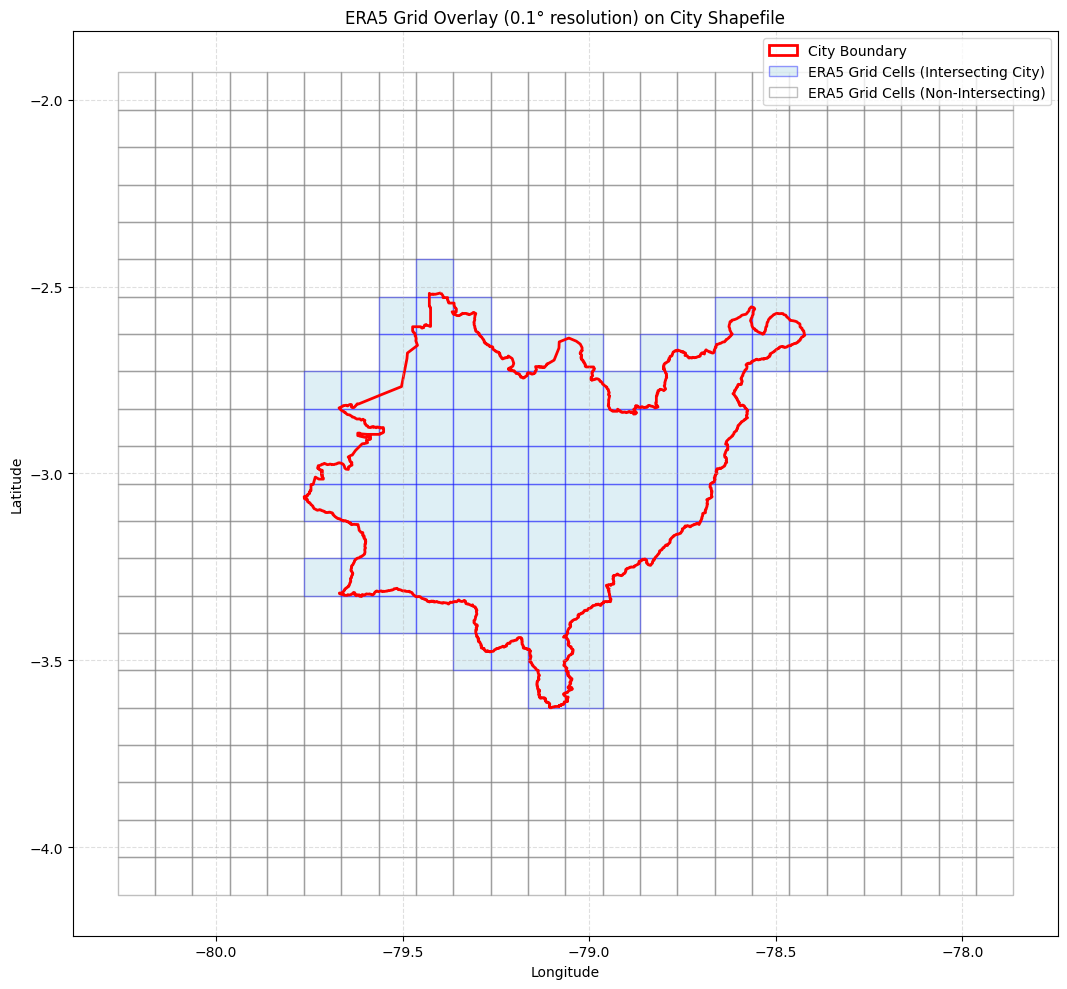

Total ERA5 grid cells in the region: 528
Grid cells intersecting the city: 99 (18.8%)


In [6]:
# Create overlay with standard ERA5 resolution (0.25°)
# fig, city_gdf, grid_gdf = create_era5_grid_overlay(azuay_shapefile_path, era5_resolution=0.25)

# To use ERA5 high-resolution (0.1°), uncomment this line:
fig, city_gdf, grid_gdf = create_era5_grid_overlay(azuay_shapefile_path, era5_resolution=0.1)

# Save the figure if needed
plt.savefig("era5_grid_overlay.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print some statistics
total_cells = len(grid_gdf)
intersecting_cells = grid_gdf['intersects_city'].sum()
print(f"Total ERA5 grid cells in the region: {total_cells}")
print(f"Grid cells intersecting the city: {intersecting_cells} ({intersecting_cells/total_cells*100:.1f}%)")

# Optionally save the grid as a GeoJSON or Shapefile
grid_gdf.to_file("era5_grid.geojson", driver="GeoJSON")